## Develop Consensus clustering

Put it into clean python file later

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from clustertools.load_data import load_fuzzy_data
from scipy.spatial import distance
from copy import deepcopy
from timeit import default_timer as timer
from datetime import timedelta
import importlib

from clustertools.models import similarity
from clustertools.models import density
from clustertools.models import distance as cl_dist

%matplotlib inline

In [2]:
fuzzy = load_fuzzy_data()
len(fuzzy)

2309

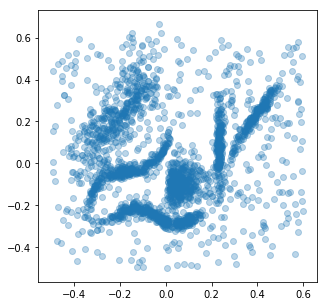

In [3]:
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[:,0], fuzzy[:,1],alpha=.3)

In [4]:
np.random.shuffle(fuzzy)

In [5]:
importlib.reload(similarity)

<module 'clustertools.models.similarity' from 'C:\\Users\\Johannes\\Desktop\\Uni\\Mathematische Aspekte in ML\\Projekt\\clustertools_project\\clustertools\\models\\similarity.py'>

In [ ]:
kmeans_obj = cl_dist.KMeans(data, 6)
kmeans_obj.fit()

Detected 11 clusters
Finished after 0:00:00.085013
Rate of noise in dataset: 0.303896


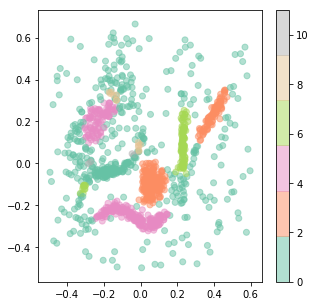

In [159]:
dbscan_obj = density.DBSCAN(data, eps=0.03, minPts=10)
dbscan_obj.fit()
labels = dbscan_obj.cluster_labels
#print((labels[:] == 'noise'))
for i in range(len(labels)):
    if labels[i] == 'noise':
        labels[i] = 0
#labels[[i for i in range(len(labels)) if labels[i] == 'noise']] = 0
#print(labels)
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
plt.colorbar()

In [140]:
hiercl_obj = similarity.HierarchicalClustering(data, k=7)
hiercl_obj.fit()

terminated by break condition
15 iterations until termination.
Finished after 0:00:00.009713
max within-cluster distance to center: 0.537728
mean within-cluster distance to center: 0.114892
sum of within cluster squared errors: 21.103322
Detected 2 clusters
Finished after 0:00:00.148790
Rate of noise in dataset: 0.079654
Hierarchical clustering terminated.
Finished after 0:00:06.382627
Stopping cluster number was reached.
Current number of clusters: 7
Current minimum cluster distance: 0.41


In [133]:
def recluster_clusters(clusterings, k=5, recluster_what='clusters', how='spectral', **kwargs):
    
    # n: number of data points, that are clustered by different algorithms
    
    m = len(clusterings)
    assert m > 0, "the list of fitted clustering objects is empty"
    assert any((recluster_what == 'clusters', recluster_what == 'points')), "unknown recluster_what-parameter"
    assert any((how == 'spectral', how == 'hierarchical')), "unknown how-parameter"
    n = len(clusterings[0].cluster_labels)
    assert all(tuple([len(clustering.cluster_labels) == n for clustering in clusterings])), "clusterings did not cluster same amount of points"
    
    # Create array of labels
    labels = np.zeros((n, m)).astype(int)
    num_unique_labels = np.zeros(m).astype(int)
    for j in range(m):
        labels[:, j] = clusterings[j].cluster_labels
        num_unique_labels[j] = len(np.unique(clusterings[j].cluster_labels))
    
    # Create hypergraph
    num_edges = np.sum(num_unique_labels).astype(int)
    hypergraph = np.zeros((num_edges, n)).astype(int)
    cluster_sum = 0
    for j in range(m): # for all clusterings
        #print(type(num_unique_labels[j]))
        for l in range(num_unique_labels[j]): # for all cluster labels
            hypergraph[cluster_sum + l, :] = (labels[:, j] == l)
        cluster_sum += num_unique_labels[j]
    
    # Berechne Distanzmatrix der Kanten
    dists = distance.squareform(distance.pdist(hypergraph, 'jaccard')) # WELCHE SEITENLÄNGE HAT DIESE MATRIX JETZT? n oder num_edges?
    # SIE MUSS: num_edges als Seitenlänge haben
    
    # Recluster
    hyperedge_clustering = None
    if how == 'hierarchical':
        hyperedge_clustering = similarity.HierarchicalClustering(dists, metric=None, k=k)
    if how == 'spectral':
        hyperedge_clustering = similarity.SpectralClustering(dists, similarity_measure=None, n=k) # SETZE VERBOSE AUF VERBOSE
    hyperedge_clustering.fit()
    hyperedge_labels = hyperedge_clustering.cluster_labels
    
    # Compete for points
    point_label_buckets = np.zeros((n, k)).astype(int) # hat alles die richtige Dimension?
    for edge_ind in range(num_edges):
        point_label_buckets[:, hyperedge_labels[edge_ind]] += hypergraph[edge_ind] # STIMMT DAS?
    cluster_labels = np.zeros(n).astype(int)
    for i in range(n):
        cluster_labels[i] = np.random.choice(np.flatnonzero(point_label_buckets[i, :] == point_label_buckets[i, :].max()))
        
    return cluster_labels

In [157]:
# Set some parameters

stride = 2
data = fuzzy[::stride]
n = len(data)

#clusterings = [kmeans_obj, kmeans_obj]
#clusterings = [hiercl_obj, hiercl_obj]
#clusterings = [kmeans_obj, hiercl_obj]
clusterings = [dbscan_obj, kmeans_obj, hiercl_obj]
recluster_what = 'clusters'
#recluster_what = 'points'
#how = 'hierarchical'
how = 'spectral'
k = 6 # how many clusters to produce

Computing generalized Laplacian eigenproblem


KMeans initialization on eigenvectors...
terminated by break condition
4 iterations until termination.
Finished after 0:00:00.012567
max within-cluster distance to center: 9.505484
mean within-cluster distance to center: 4.041731
sum of within cluster squared errors: 640.539397
KMeans terminated. 

Finished after 0:00:00.015643


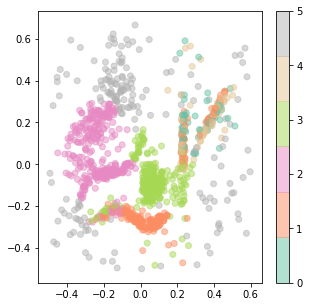

In [158]:
labels = recluster_clusters(clusterings=clusterings, k=k, recluster_what=recluster_what, how=how) # kwargs-handling noch
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
plt.colorbar()

Plot hierarchical

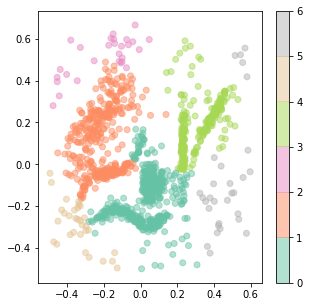

In [63]:
labels = hiercl_obj.cluster_labels
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
plt.colorbar()

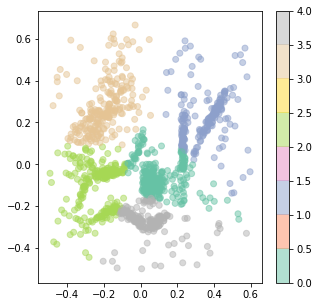

In [120]:
labels = kmeans_obj.cluster_labels
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
plt.colorbar()

Plot KMeans

In [57]:
np.flatnonzero(np.array([0, 0, 0, 1, 0, 0, 1, 1]))

array([3, 6, 7], dtype=int64)

In [55]:
np.random.choice([0, 2, 5])

0

In [26]:
test = np.array([[0, 0, 0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1, 1, 1]])
test2 = np.array([[0, 0, 0, 0, 1, 1, 1, 1],
                  [0, 0, 0, 1, 0, 0, 1, 1]])
test3 = np.array([[0, 0, 0, 1, 1, 1, 1, 1],
                  [0, 0, 0, 1, 1, 1, 1, 1]])
print(test)
print(test2)
print(test3)
print(distance.squareform(distance.pdist(test, 'jaccard')))
print(distance.squareform(distance.pdist(test2, 'jaccard')))
print(distance.squareform(distance.pdist(test3, 'jaccard')))

[[0 0 0 0 0 1 1 1]
 [0 0 0 1 1 1 1 1]]
[[0 0 0 0 1 1 1 1]
 [0 0 0 1 0 0 1 1]]
[[0 0 0 1 1 1 1 1]
 [0 0 0 1 1 1 1 1]]
[[ 0.   0.4]
 [ 0.4  0. ]]
[[ 0.   0.6]
 [ 0.6  0. ]]
[[ 0.  0.]
 [ 0.  0.]]


In [22]:
1 - np.arange(4).reshape((2, 2))

array([[ 1,  0],
       [-1, -2]])

In [23]:
np.arange(4)

array([0, 1, 2, 3])